IGH N1 zone analysis

In [4]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import os
from scipy.optimize import minimize
from scipy.stats import chisquare
import collections
import csv

1. Model definition

In [28]:
def pnpe(n, pp, pn, pe):
    if n > 0:
        prob = ((pe**2*pn*pp**2*((n-1)*(pe*(1-pp))**(n-2)))/((pn-pp)*(pe+pp-pe*pp)**(n+2))) + ((pe*pn*pp**2*(pe*(1-pn))**n)/((pn-pp)**2*(pe-pe*pn)*(pe+pn-pe*pn)**(n+1))) - ((pe*pn*pp**2 * (pe*(1-pp))**n * (pe-2*pn + 3*pp + 2* pe*pn - 3 *pe*pp))/((pn - pp)**2*(pe-pe*pp)*(pe + pp - pe*pp)**(n+2)))
        return prob
    #probability of zero-length of the N1 zone = 0
    elif n == 0: 
        prob = 0
        return prob
    else:
        prob = ((pe**2*pn*pp**2*((1/(pe**2*(pp-1)**2))+(((n-1)*((-pe*(pp-1))/(pe+pp-pe*pp))**(n-2))/((pe+pp-pe*pp)**2))))/((pn-pp)*(pe-pp-pe*pp)**2)) - ((pn*pp**2*(pe-1)**3)/((pe+pn - pe*pn)*(pe+pp - pe*pp)**2)) +((pe*pn*pp**2*(((-pe*(pn-1))/(pe+pn-pe*pn))**n-1))/((pn-pp)**2*(pe-pe*pn)*(pe+pn-pe*pn))) - ((pe*pn*pp**2*(((-pe*(pp-1))/(pe+pp-pe*pp))**n-1)*(pe-2*pn+3*pp+2*pe*pn - 3*pe*pp))/((pn - pp)**2*(pe-pe*pp)*(pe+pp-pe*pp)**2))
        return prob

#Maximum likelihood function is used for parameters optimization
def likelihood(params): 
    pp, pn, pe = params[0], params[1], params[2]
    return -np.sum([(y_exp_norm[x0-1])*np.log(pnpe(x0, pp, pn, pe)) for x0 in x_exp])

In [42]:
#Brutforce method of searching the best combination of initial parameters. Last time it was [0.91, 0.81, 0.01] and I actually use this

def optimize_initial_guess():
    aa = np.meshgrid(np.arange(0.01, 1, 0.1), np.arange(0.01, 1, 0.1), np.arange(0.01, 1, 0.1)) #чтобы перебрать 1 млн комбинаций, измените шаг на 0.01
    coord_list = [entry.ravel() for entry in aa]
    points = np.vstack(coord_list).T
    res_dict = {}
    n = 0
    #minimization of ML function
    for point in points: 
        result = minimize(likelihood, x0=point, bounds=((0.2, 0.999), (0.01, 0.999), (0.01, 0.999))) #minimization of ML function
        res_dict[result.fun] = point
        n+=1
    key_list = [x for x in res_dict.keys() if str(x) != 'nan']
    return res_dict[min(key_list)]

In [5]:
list1 = ['ID','pp', 'pn', 'pe', "N"] #create empty csv file for parameters and sampling sizes
with open("parameters.csv", "a", newline='') as fp:
    wr = csv.writer(fp, dialect='excel')
    wr.writerow(list1)

In [26]:
all_data = []

In [24]:
samples = os.listdir("data")
samples.sort()
samples = samples[1:]

2. Parse V-quest output and model training

In [30]:
for sample in samples:
    #parse V-quest output
    IMGT_read_data = pd.read_csv("data/" + sample + "/3_Nt-sequences.txt", sep='\t')
    IMGT_filtered = IMGT_read_data[['Sequence ID', 'V-DOMAIN Functionality', 'V-REGION end', 'D-REGION start']]
    IMGT_productive = IMGT_filtered[IMGT_filtered["V-DOMAIN Functionality"] == "productive"]
    IMGT_productive = IMGT_productive.dropna()
    IMGT_productive["lens_n1"] = IMGT_productive['D-REGION start'] - IMGT_productive['V-REGION end'] - 1
    IMGT_productive = IMGT_productive.sort_values(by = ["lens_n1"])
    
    #prepare model input. x - lengths of N1 zone, y_exp - frequency of lengths in real data
    c = collections.Counter()
    for length in list(IMGT_productive["lens_n1"]):
        c[length] +=1
    x_exp = list(np.arange(1, 51))
    y_exp = [c[x] for x in x_exp]
    y_exp_norm = [y / sum(y_exp) for y in y_exp]
    
    #train model
    initial_guess = np.array([0.91, 0.81, 0.01])
    result = minimize(likelihood, x0=initial_guess, bounds=((0.2, 0.999), (0.01, 0.999), (0.001, 0.999))) #minimization of ML function
    coeff = result.x
    y = [pnpe(z, coeff[0], coeff[1], coeff[2]) for z in x_exp]
    all_data.append([x_exp, y_exp_norm, y, sample])
    
    #write parameters to csv
    a = list(result.x)
    a.insert(0, sample)
    a.append(sum(IMGT_filtered["V-DOMAIN Functionality"] == "productive"))
    with open("parameters.csv", "a", newline='') as fp:
        wr = csv.writer(fp, dialect='excel')
        wr.writerow(a)
    #write distribution to csv
    csv_path = "data/" + sample + "/distribution.csv"
    pd.DataFrame([x_exp, y_exp_norm, y]).T.to_csv(csv_path, header = ["Length", "Freq", "Freq_model"], index = False)


/Users/irina/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/irina/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3. Visualization for all samples

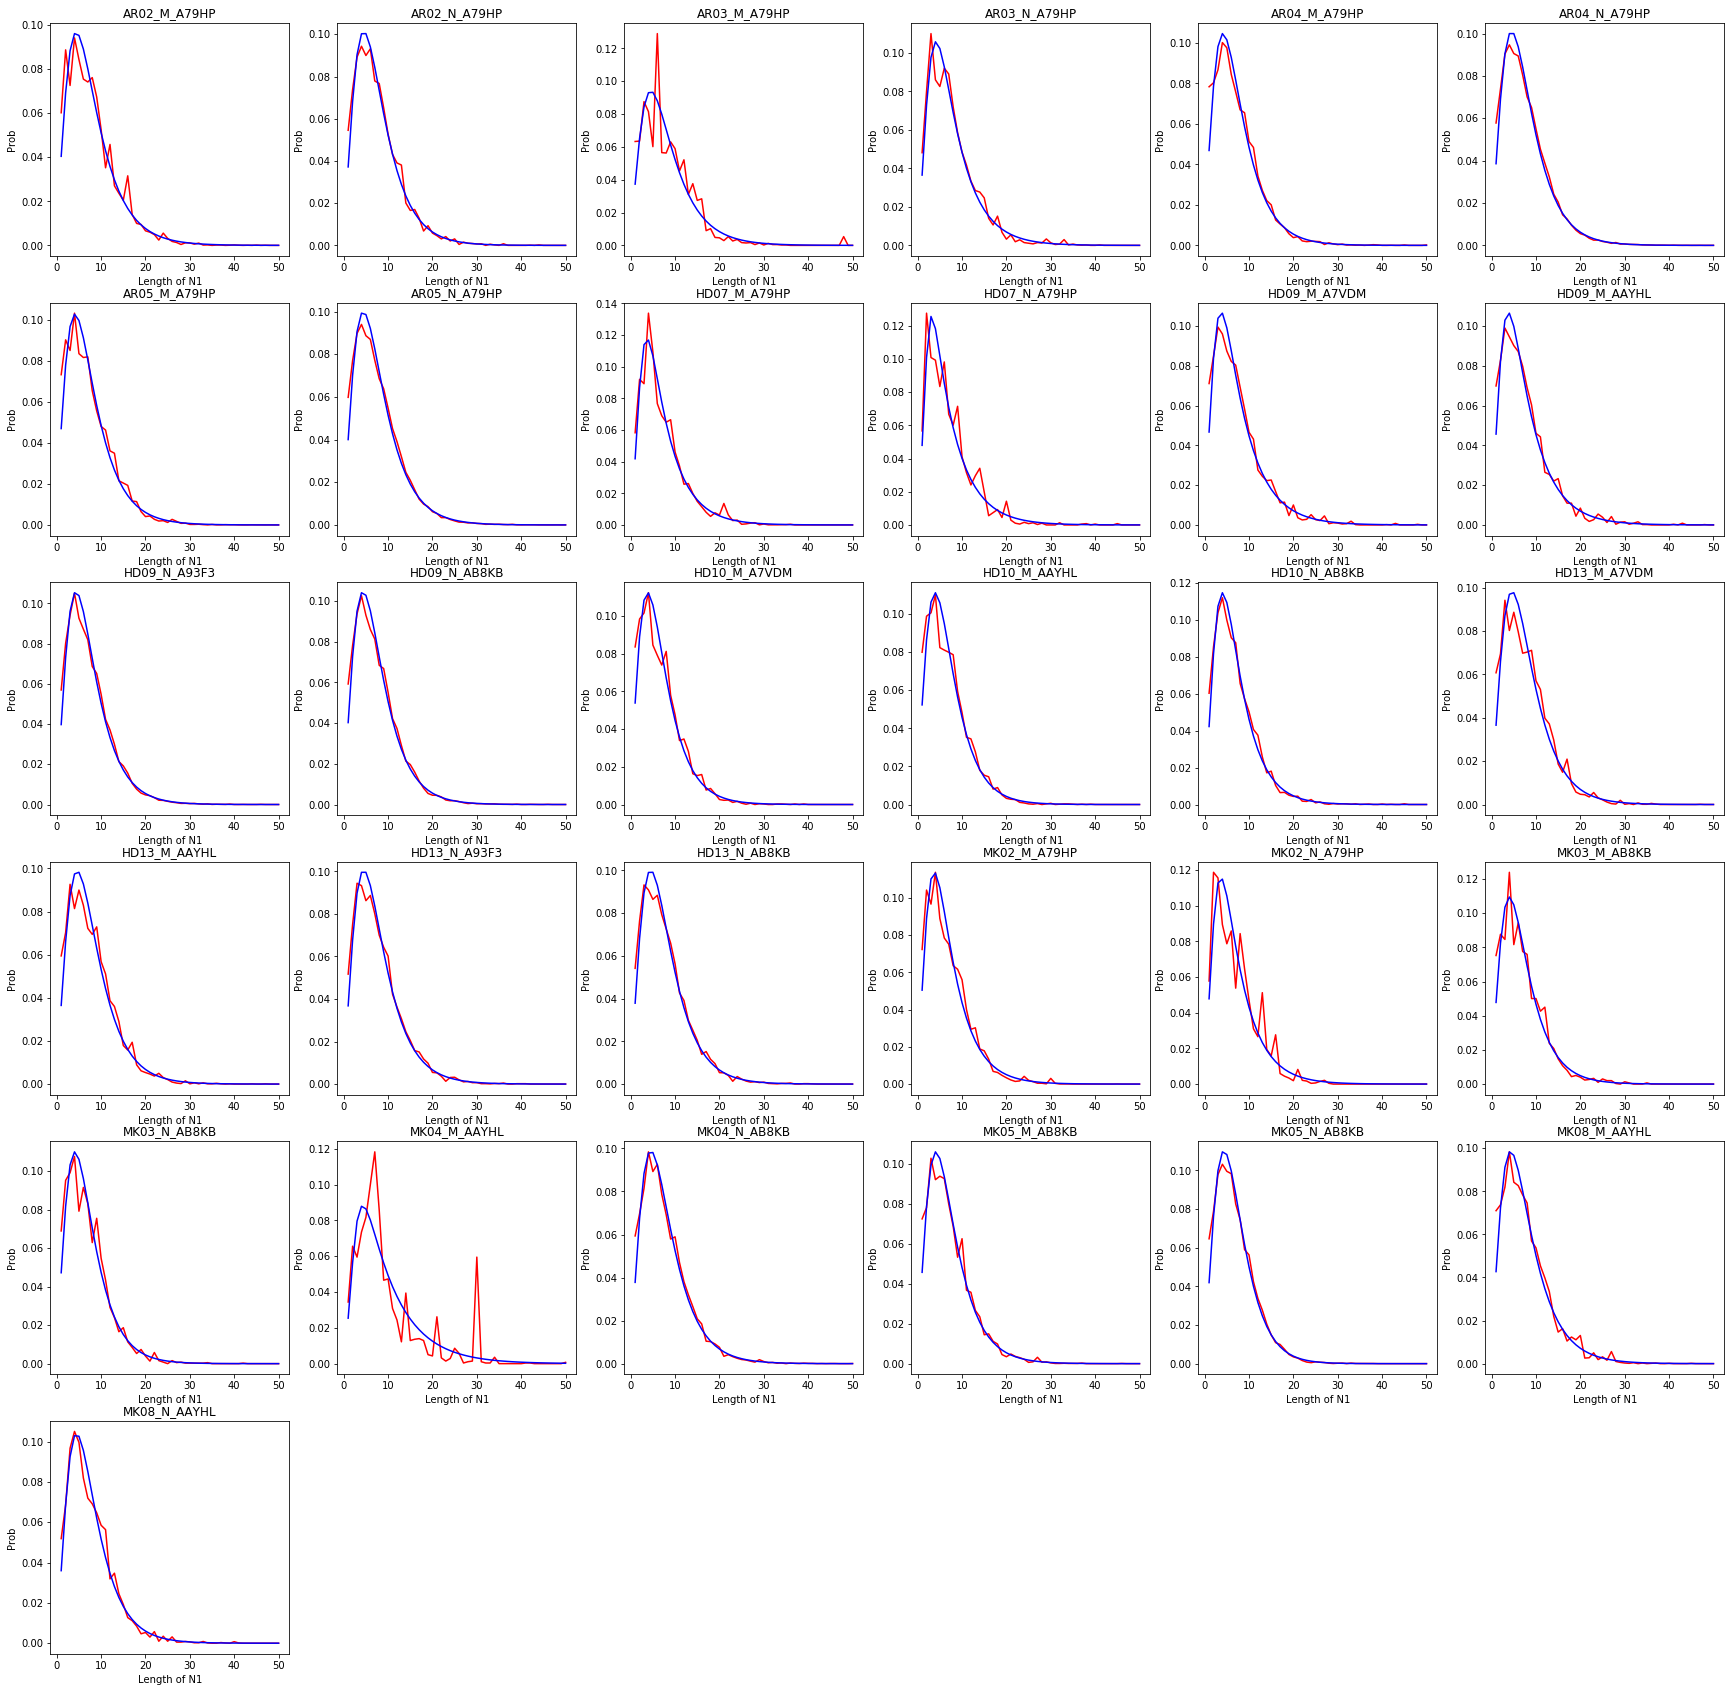

In [35]:
fig = plt.figure(figsize=(30, 30)) #visualization
columns = 6
rows = 6
for i in range(1, 32):
    fig.add_subplot(rows, columns, i)
    plt.plot(all_data[i - 1][0], all_data[i - 1][1], color="red")
    plt.plot(all_data[i - 1][0], all_data[i - 1][2], color="blue")
    plt.xlabel("Length of N1")
    plt.ylabel("Prob")
    plt.title(str(all_data[i - 1][3]))
plt.savefig('pheno.png', bbox_inches='tight')